# Importing libraries

What this does:

numpy, pandas → general data handling (we mainly use numpy here).

random → pick random samples for display.

tensorflow as tf → main DL library; Keras is included inside TF.

matplotlib.pyplot → plotting images and training graphs.

accuracy_score (sklearn) → final numeric accuracy metric.

Keras imports: Sequential model class, common layers (Flatten, Conv2D, Dense, MaxPooling2D), optimizer SGD, utility to_categorical (not actually used in your code but imported), and mnist dataset loader.

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dense,MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Loading and preparing the data

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
print(X_train.shape)

(60000, 28, 28)


In [4]:
X_train[0].min(), X_train[0].max()

(np.uint8(0), np.uint8(255))

In [5]:
X_train = (X_train - 0.0) / (255.0 - 0.0)
X_test = (X_test - 0.0) / (255.0 - 0.0)
X_train[0].min(), X_train[0].max()

(np.float64(0.0), np.float64(1.0))

Visualize some training imagesWhat this does:

plot_digit is a helper function to draw one image and title it with the label.

Plots first 20 training images in a 4×5 grid so you can visually inspect examples and their labels.

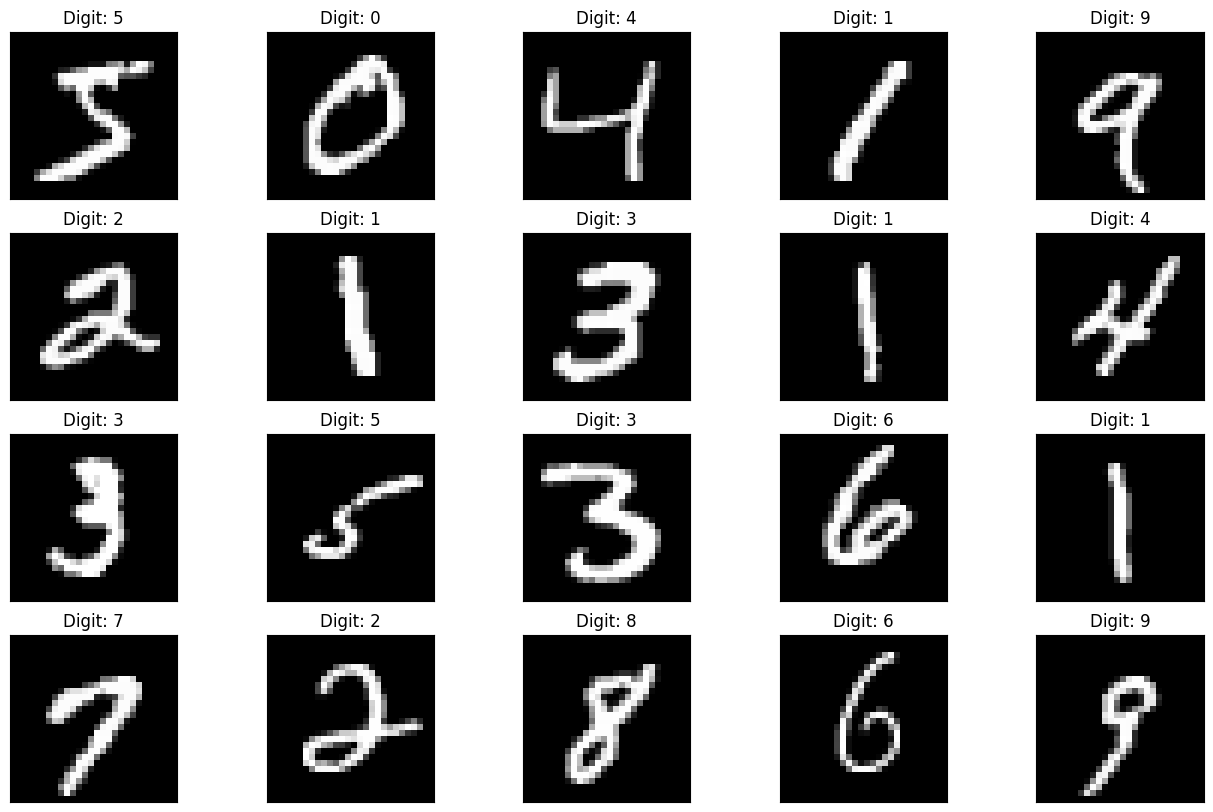

In [6]:
def plot_digit(image, digit, plt, i):
 plt.subplot(4, 5, i + 1)
 plt.imshow(image, cmap=plt.get_cmap('gray'))
 plt.title(f"Digit: {digit}")
 plt.xticks([])
 plt.yticks([])
plt.figure(figsize=(16, 10))
for i in range(20):
 plot_digit(X_train[i], y_train[i], plt, i)
plt.show()

What this does:

CNN layers expect a channel dimension. reshape converts shape from (60000,28,28) → (60000,28,28,1) where 1 is the grayscale channel.
 The extra dimension (1) represents
 the color channel. For grayscale images, it's 1; for RGB, it's 3
y_train[0:20] simply shows first 20 labels (not used further).

Reshape images to include channel dimension

In [7]:
X_train = X_train.reshape((X_train.shape + (1,)))
X_test = X_test.reshape((X_test.shape + (1,)))
y_train[0:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

# Creating the Model
Now line-by-line explanation of the model:

Sequential([...]) — model where layers are stacked in order.

Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)) — 2D convolution layer with 32 filters, each 3×3; ReLU activation; receives input images of shape 28×28 with 1 channel. Convolution learns local features (edges, strokes). Output feature map shape: (26,26,32) before pooling (because no padding default).

MaxPooling2D((2,2)) — reduces spatial size by taking max in each 2×2 window. Helps downsample and make features translation invariant. After pooling, shape becomes roughly (13,13,32).

Flatten() — converts feature maps into 1D vector so Dense layers can process them. If previous layer output was (13,13,32), flattened size = 13*13*32 = 5408.

Dense(100, activation='relu') — fully connected hidden layer with 100 neurons; learns higher-level combinations of features.

Dense(10, activation='softmax') — final output layer with 10 neurons for classes 0–9; softmax returns class probabilities.

In [8]:
model = Sequential([
 Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
 MaxPooling2D((2, 2)),
 Flatten(),
 Dense(100, activation="relu"),
 Dense(10, activation="softmax")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(
 optimizer=optimizer,
 loss="sparse_categorical_crossentropy",
 metrics=["accuracy"]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model
“The model.fit() function trains the model on the training data (X_train, y_train) for 10 epochs. The validation_data parameter checks model performance on test data after each epoch. The training progress — accuracy and loss — is stored in the history variable for later visualization.”

In [10]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8726 - loss: 0.4355 - val_accuracy: 0.9684 - val_loss: 0.1004
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9765 - loss: 0.0804 - val_accuracy: 0.9810 - val_loss: 0.0563
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9853 - loss: 0.0490 - val_accuracy: 0.9812 - val_loss: 0.0518
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9865 - val_loss: 0.0408
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9930 - loss: 0.0231 - val_accuracy: 0.9858 - val_loss: 0.0449
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9949 - loss: 0.0181 - val_accuracy: 0.9877 - val_loss: 0.0386
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9961 - loss: 0.0130 - val_accuracy: 0.9866 - val_loss: 0.0439
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9975 - loss: 0.0093 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


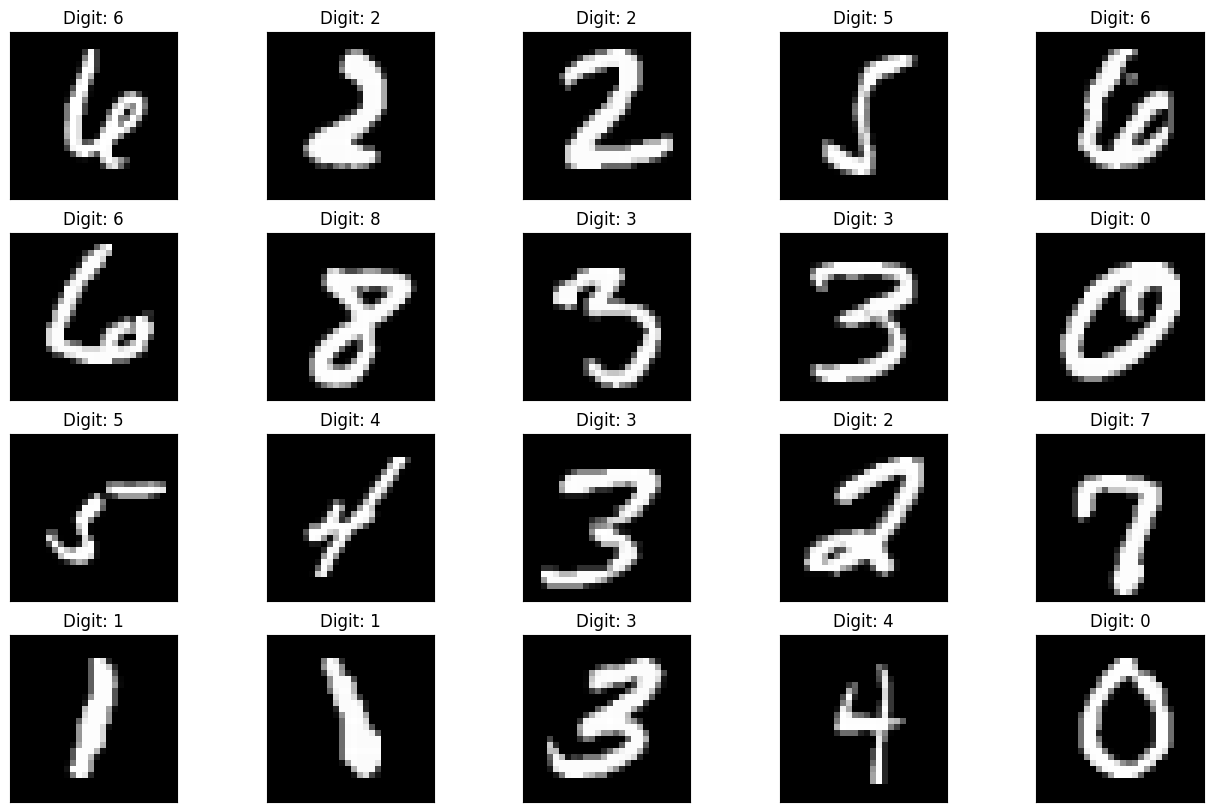

In [11]:
plt.figure(figsize=(16, 10))
for i in range(20):
 image = random.choice(X_test).squeeze()
 digit = np.argmax(model.predict(image.reshape((1, 28, 28, 1)))[0], axis=-1)
 plot_digit(image, digit, plt, i)
plt.show()

In [12]:
predictions = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.9888

# Estimating the model's performance

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])    #Test Loss
print('Test accuracy:', score[1])    #Test Accuracy

Test loss: 0.037714868783950806
Test accuracy: 0.9887999892234802


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(epochs)

<Figure size 640x480 with 0 Axes>

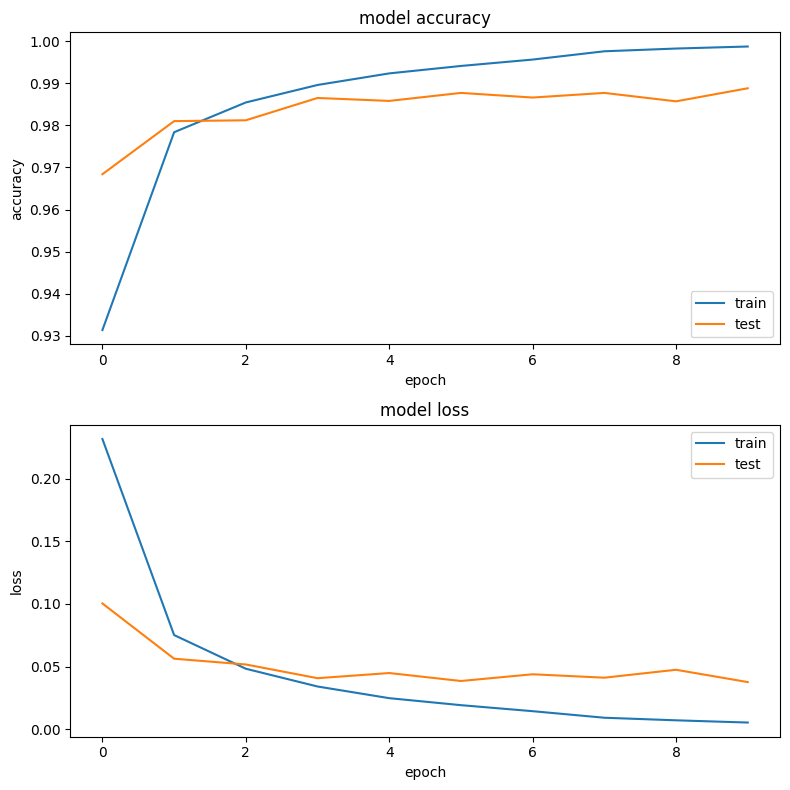

In [15]:
import os
# plotting the metrics
fig = plt.figure()
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')


plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [16]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("model_digit.json", "w") as json_file:
 json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("model_digit.weights.h5")
print("Saved model to disk")

Saved model to disk
